# COMP9418 - Assignment 1 - Bayesian Networks as Classifiers

## UNSW Sydney, September 2021

- Haodong Lu - Z5183944
- Yiyan Yang - Z5183946

## Instructions

**Submission deadline:** Sunday, 17th October 2021, at 18:00:00.

**Late Submission Policy:** The penalty is set at 20% per late day. This is ceiling penalty, so if a group is marked 60/100 and they submitted two days late, they still get 60/100.

**Form of Submission:** This is a group assignment. Each group can have up to **two** students. **Only one member of the group should submit the assignment**.

You can reuse any piece of source code developed in the tutorials.

Submit your files using give. On a CSE Linux machine, type the following on the command-line:

``$ give cs9418 ass1 solution.zip``

Alternative, you can submit your solution via [WebCMS](https://webcms3.cse.unsw.edu.au/COMP9418/21T3).

## Technical prerequisites

These are the libraries your are allowed to use. No other libraries will be accepted. Make sure you are using Python 3.

In [1]:
# Allowed libraries
import numpy as np
import pandas as pd
import scipy as sp
import heapq as pq
import matplotlib as mp
import math
from itertools import product, combinations
from graphviz import Digraph
from tabulate import tabulate
import copy

We can also use the python files we developed in tutorials, or any other code from the tutorials.

In [2]:
from DiscreteFactors import Factor
from Graph import Graph
from BayesNet import allEqualThisIndex, estimateFactor, BayesNet

## Initial task - Initialise graph

Create a graph ``G`` that represents the following network by filling in the edge lists.
![Bayes Net](BayesNet.png)


In [3]:
G = Graph({
    "BreastDensity" : ["Mass"],
    "Location" : ["BC"],
    "Age" : ["BC"],
    "BC" : ["Metastasis", "MC", "SkinRetract", "NippleDischarge", "AD", "Mass"],
    "Mass" : ["Size", "Shape", "Margin"],
    "AD" : ["FibrTissueDev"],
    "Metastasis" : ["LymphNodes"],
    "MC" : [],
    "Size" : [],
    "Shape" : [],
    "FibrTissueDev" : ["SkinRetract", "NippleDischarge", "Spiculation"],
    "LymphNodes" : [],
    "SkinRetract" : [],
    "NippleDischarge" : [],
    "Spiculation" : ["Margin"],
    "Margin" : [],
})

# G.show()

### Load data

In [4]:
# load data
with open('bc.csv') as file:
    data = pd.read_csv(file)

#remove 2 variables from data (because we are pretending we don't know this information)
if 'Metastasis' in data:
    del data['Metastasis']
if 'LymphNodes' in data:
    del data['LymphNodes']

# remove same 2 nodes from graph
G.remove_node('Metastasis')
G.remove_node('LymphNodes')

## [20 Marks] Task 1 - Efficient d-separation test

Implement the efficient version of the d-separation algorithm in a function ``d_separation(G, X, Z, Y)`` that return a boolean: ``True`` if **X** is d-separated from **Y** given **Z** in the graph $G$ and ``False`` otherwise.

* **X**,**Y** and **Z** are python sets, each containing a set of variable names. 
* Variable names may be strings or integers, and can be assumed to be nodes of the graph $G$. 
* $G$ is a directed graph object as defined in tutorial 1.

In [5]:
## Develop your code for d_separation(G, X, Z, Y) in one or more cells here

The d-seperation $dsep_G(X,Y,Z)$ is implemented by first repeatedly pruning leaf nodes not belong to $X \vee Y \vee Z$ and then pruning all edges outgoing from nodes in $Z$. Then we test the connectivity between $X$ and $Y$ by making an undirected copy of the pruned graph and then using DFS to traverse from the set of nodes in $X$ to the set of nodes in $Y$. If they are connected then $X$ and $Y$ are d-seperated by $Z$, and vise-versa. Note that based on the definition of d-seperation where $dsep_G(X,Y,Z)$ is $True$ iff every path between a node in $X$ and a node in $Y$ is blocked by $Z$, we set that the connectivity check fails if there is one node in $X$ cannot traverse to a node in $Y$ and that would result in $dsep_G(X,Y,Z)$ is $True$.

In [6]:
# helper functions
def to_undirected(g):
    ug = Graph()
    for node in g:
        ug.add_node(node)
        for edge in g.children(node):
            ug.add_edge(node, edge, directed=False)
    return ug

def connectivity_check(G, X, Y):
    x2y = True
    for node_x in X:
        for node_y in Y:
            if G.dfs(node_x)[node_y] == "white":
                x2y = False
                break
    return x2y


In [7]:
def d_separation(G, X, Z, Y):
    '''
    Arguments:
    G:   is an object of type Graph (the class you developed in tutorial 1)
    X,Z and Y:  are python `set` objects.
    '''
    # 1. We delete any leaf node W from DAG G as long as W does not belong to X ∪ Y ∪ Z. This process is
    # repeated until no more nodes can be deleted.
    G_copy = copy.deepcopy(G)
    union = X.union(Y,Z)

    pruned = False
    while not pruned:
        pruned = True
        leaf_nodes = []
        for node in G_copy:
            if len(G_copy.children(node)) == 0:
                leaf_nodes.append(node)
        for leaf in leaf_nodes:
            if leaf not in union:
                pruned = False
                G_copy.remove_node(leaf)

    # 2. We delete all edges outgoing from nodes in Z
    for node in Z:
        G_copy.adj_list[node] = []


    # 3. Check connectivity
    return not connectivity_check(to_undirected(G_copy), X, Y)



In [8]:
############
## TEST CODE
## Note: More hidden tests will be used. You should make more tests yourself.

def test(statement):
    if statement:
        print("Passed test case")
    else:
        print("Failed test case")
        
test(d_separation(G, set(['Age']), set(['BC']), set(['AD'])))
test(not d_separation(G, set(['Spiculation','SkinRetract']), set(['MC', 'Size']), set(['Age'])))

Passed test case
Passed test case


In [9]:
# my tests

# test sequential true
test(d_separation(G, set(['BC']),  set(['Mass']), set(['Size'])))
test(d_separation(G, set(['BC']), set(['AD']), set(['FibrTissueDev'])))
test(d_separation(G, set(['BC']), set(['Mass','AD']), set(['Margin','FibrTissueDev'])))
# test sequential false
test(not d_separation(G, set(['BC']),  set(['Mass']), set(['Margin'])))

# test divergent true
test(d_separation(G, set(['Mass']),  set(['BC']), set(['SkinRetract'])))
test(d_separation(G, set(['NippleDischarge']),  set(['FibrTissueDev', 'BC']), set(['SkinRetract'])))
# test divergent false
test(not d_separation(G, set(['NippleDischarge']),  set(['FibrTissueDev']), set(['SkinRetract'])))

# test convergent true
test(d_separation(G, set(['Mass']), set(['BC']), set(['Spiculation'])))
# test convergent false
test(not d_separation(G, set(['Mass']),  set(['BC', 'Margin']), set(['Spiculation'])))
test(not d_separation(G, set(['Location']),  set(['BC']), set(['Age'])))

Passed test case
Passed test case
Passed test case
Passed test case
Passed test case
Passed test case
Passed test case
Passed test case
Passed test case
Passed test case


## [10 Marks] Task 2 - Estimate Bayesian Network parameters from data

Implement a function ``learn_outcome_space(data)`` that learns the outcome space (the valid values for each variable) from the pandas dataframe ``data`` and returns a dictionary ``outcomeSpace`` with these values.

Implement a method ``model.learn_parameters(data, alpha=1)`` that learns the parameters of the Bayesian Network `model`. This function should do the same as the ``learn_parameters`` function from tutorials, but it should also implement laplacian smoothing with parameter $\alpha$.

In [10]:
## Develop your code for learn_outcome_space(data) in one or more cells here

In [11]:
def learn_outcome_space(data):
    '''
    Arguments:
        data - A pandas dataframe
    Returns: 
        outcomeSpace - A dictionary. e.g. {'A':('True', 'False'), 'B':('up','down','left'), 'C':(1,2,3,4)}
    '''
    outcomeSpace = {}
    for key in data:
        outcomeSpace[key] = tuple(set(data[key]))

    return outcomeSpace


In [12]:
############
## TEST CODE

outcomeSpace = learn_outcome_space(data)

outcomes = outcomeSpace['BreastDensity']
answer = ('high', 'medium', 'low')
test(len(outcomes) == len(answer) and set(outcomes) == set(answer))

Passed test case


In [13]:
## Develop your code for learnParameters in one or more cells here

In [14]:
# helper function
def estimateFactor_alpha(data, var_name, parent_names, outcomeSpace, alpha=1, log=False):
    var_outcomes = outcomeSpace[var_name]
    parent_outcomes = [outcomeSpace[var] for var in (parent_names)]
    # cartesian product to generate a table of all possible outcomes
    all_parent_combinations = product(*parent_outcomes)

    # calculating the number of values for X (|X|)
    mod_X = len(var_outcomes)
    for p in parent_outcomes:
        mod_X *= len(p)

    f = Factor(list(parent_names)+[var_name], outcomeSpace)
    
    for i, parent_combination in enumerate(all_parent_combinations):
        parent_vars = dict(zip(parent_names, parent_combination))
        parent_index = allEqualThisIndex(data, **parent_vars)
        for var_outcome in var_outcomes:
            var_index = (np.asarray(data[var_name])==var_outcome)
            if log:
                f[tuple(list(parent_combination)+[var_outcome])] = np.log2(((var_index & parent_index).sum()+alpha)/(parent_index.sum() + alpha*mod_X))
            else:
                f[tuple(list(parent_combination)+[var_outcome])] = ((var_index & parent_index).sum()+alpha)/(parent_index.sum() + alpha*mod_X)
        
            
    return f

In [15]:
class BayesNet(BayesNet):
    def learn_parameters(self, data, alpha=1, log=False):
        graphT = self.graph.transpose()
        for node, parents in graphT.adj_list.items():
            f = estimateFactor_alpha(data, node, parents, self.outcomeSpace, alpha, log)
            self.factors[node] = f
            
model = BayesNet(graph=G, outcomeSpace=outcomeSpace)

In [16]:
############
## TEST CODE

model.learn_parameters(data, alpha=1)

test(model.factors['Age']['35-49'] == 0.248000399920016)
print(model.factors['Age']['35-49'] )

Passed test case
0.248000399920016


## [20 Marks] Task 3 - Bayesian Network Classification

Design a new function ``assess_bayes_net(model, dataframe, var)`` that uses the test cases in ``dataframe`` to assess the performance of the Bayesian network at classifying the variable `var`. Implement the efficient classification procedure discussed in the lectures (make sure you understand what a Markov Blanket is). Such a function should return the classifier accuracy. 

 * ``var`` is the name of the variable you are predicting, using the values of all the other variables. 
 
If you like, you can add new functions to the BayesNet class, or write helper functions to help solve the above task.

Using another function called `cross_validation_bayes_net`, compute and report the average accuracy over the ten cross-validation runs as well as the standard deviation. A scaffold for this function is provided below.

In [17]:
## Develop your code for assess_bayes_net in one or more cells here

In [18]:
model = BayesNet(graph=G, outcomeSpace=outcomeSpace)
def assess_bayes_net(model, dataframe, var='BC'):
    evidence = {}
    prob = []
    num_keys = dataframe.shape[0]

    for i in range(0, num_keys):
        for d in dataframe:
            if d == var:
                continue
            evidence[d] = dataframe[d].iloc[i]
        probi = model.query([var], **evidence)
        tb = probi.table
        index = np.argmax(tb)
        prob.append(probi.outcomeSpace[probi.domain[0]][index])
    
    '''
    for i in range(0, num_keys):
        print(prob[i].table, prob[i].outcomeSpace[prob[i].domain[0]][0])
    '''
    # List of real var values
    true_value = dataframe[var]
    # Predicted var values
    predict_value = pd.Series(prob)

    # Mean accuracy
    acc = (((predict_value == true_value)).mean())

    return acc

def cv_bayes(dataframe, var='BC', k=10):
    accuracy_list = []
    for i in range(k):
        model = BayesNet(graph=G, outcomeSpace=outcomeSpace)
        # split dataset into train and test
        
        # train a model
        start = int(i*dataframe.shape[0]/k)
        end = int((i+1)*dataframe.shape[0]/k)
        train = dataframe.drop([i for i in range(start, end)], axis=0)
        test = dataframe.iloc[start:end]
        train = train.reset_index()
        test = test.reset_index()
        train.drop(columns=["index"])
        test.drop(columns=["index"])

        # model.learnParameters
        model.learn_parameters(train, alpha=1)

        # test the model with assess_bayes_net
        acc = assess_bayes_net(model, test, var)
        
        accuracy_list.append(acc)
    return accuracy_list

def cross_validation_bayes_net(dataframe, var='BC', k=10):
    accuracy_list = cv_bayes(dataframe, var, k)
    return np.mean(accuracy_list), np.std(accuracy_list)


In [19]:
############
## TEST CODE

acc, stddev = cross_validation_bayes_net(data, 'BC', 10)
test(abs(acc - 0.85) < 0.05)

Passed test case


## [10 Marks] Task 4 - Naïve Bayes Classification

Design a new function ``assess_naive_bayes(model, data, var)`` to classify and assess the test cases in ``data``. To classify each example, use the log probability trick discussed in the lectures. Do $k$-fold cross-validation with the `cross_validation_naive_bayes(data, var, k)` function, same as above, and return ``acc`` and ``stddev``.

In [20]:
## Develop your code for assess_naive_bayes(model, data, var) in one or more cells here

In [21]:
# helper function to generate a graph for naive bayse network
def get_naive_g(outcomeSpace, var="BC"):
    naive_g = {
        var: []
    }
    for key in outcomeSpace:
        if key != var:
            naive_g[var].append(key)
            naive_g[key] = []

    naive_g = Graph(naive_g)

    return naive_g

# modified version of tut code to join log probalility tables
class Factor(Factor):
    def log_join(self, other):
        '''
        This function multiplies two factors.
        '''
        # confirm that any shared variables have the same outcomeSpace
        for var in set(other.domain).intersection(set(self.domain)):
            if self.outcomeSpace[var] != other.outcomeSpace[var]:
                raise IndexError('Incompatible outcomeSpaces. Make sure you set the same evidence on all factors')

        # extend current domain with any new variables required
        new_dom = list(self.domain) + list(set(other.domain) - set(self.domain)) 
        
        # to prepare for multiplying arrays, we need to make sure both arrays have the correct number of axes
        self_t = self.table
        other_t = other.table
        for _ in set(other.domain) - set(self.domain):
            self_t = self_t[..., np.newaxis]     
        for _ in set(self.domain) - set(other.domain):
            other_t = other_t[..., np.newaxis]

        # And we need the new axes to be transposed to the correct location
        old_order = list(other.domain) + list(set(self.domain) - set(other.domain)) 
        new_order = []
        for v in new_dom:
            new_order.append(old_order.index(v))
        other_t = np.transpose(other_t, new_order)
        
        # Now that the arrays are all set up, we can rely on numpy broadcasting to work out which numbers need to be multiplied.
        # https://numpy.org/doc/stable/user/basics.broadcasting.html
        new_table = self_t + other_t
        
        # The final step is to create the new outcomeSpace
        new_outcomeSpace = self.outcomeSpace.copy()
        new_outcomeSpace.update(other.outcomeSpace)

        # in the following line, `self.__class__` is the same as `Factor` (except it doesn't break things when subclassing)
        return self.__class__(tuple(new_dom), new_outcomeSpace, table=new_table)

# modified version of tut code for query on log probability tables
class BayesNet(BayesNet):
    def log_query(self, var, **q_evi):
        backup_factors = copy.deepcopy(self.factors)
        # set evidence on all relevant factors 
        for key, factor in self.factors.items():
            self.factors[key] = factor.evidence(**q_evi)

        factor_list = list(self.factors.values())
        
        accumulator = factor_list[0]
        for factor in factor_list[1:]:
            accumulator = accumulator.log_join(factor)

        for var in self.outcomeSpace:
            if var != var:
                accumulator = accumulator.marginalize(var)

        accumulator.table = np.exp2(accumulator.table)

        self.factors = backup_factors
        return accumulator.normalize()

In [22]:
def assess_naive_bayes(model, dataframe, var='BC'):
    evidence = {}
    prob = []
    num_keys = dataframe.shape[0]

    for i in range(0, num_keys):
        for d in dataframe:
            if d == var:
                continue
            evidence[d] = dataframe[d].iloc[i]
        probi = model.log_query([var], **evidence)
        tb = probi.table
        index = np.argmax(tb)
        prob.append(probi.outcomeSpace[probi.domain[0]][index])

    # List of real var values
    true_value = dataframe[var]
    # Predicted var values
    predict_value = pd.Series(prob)

    # Mean accuracy
    acc = (((predict_value == true_value)).mean())
    return acc

def cv_naive(dataframe, var='BC', k=10):
    accuracy_list = []
    # value init
    # note that graph structure is directly learned from data given var
    naive_g = get_naive_g(outcomeSpace, var)
    # suffle the dataframe
    dataframe = dataframe.sample(frac=1)
    for i in range(k):
        # split dataset into train and test
        start = int(i*dataframe.shape[0]/k)
        end = int((i+1)*dataframe.shape[0]/k)
        train = dataframe.drop([i for i in range(start, end)], axis=0)
        test = dataframe.iloc[start:end]
        train = train.reset_index()
        test = test.reset_index()
        train.drop(columns=["index"])
        test.drop(columns=["index"])

        # train a model
        model = BayesNet(graph=naive_g, outcomeSpace=outcomeSpace)

        # model.learnParameters
        model.learn_parameters(train, alpha=1, log=True)

        # test the model with assess_bayes_net
        acc = assess_naive_bayes(model, test, var)

        accuracy_list.append(acc)
    return accuracy_list

def cross_validation_naive_bayes(dataframe, var='BC', k=10):
    accuracy_list = cv_naive(dataframe, var, k)
    return np.mean(accuracy_list), np.std(accuracy_list)


In [23]:
############
## TEST CODE

acc, stddev = cross_validation_naive_bayes(data, 'BC')
test(abs(acc - 0.80) < 0.05)

Passed test case


## [20 Marks] Task 5 - Tree-augmented Naïve Bayes Classification

Similarly to the previous task, implement a Tree-augmented Naïve Bayes (TAN) classifier and evaluate your implementation in the breast cancer dataset. Design a function ``learn_tan_structure(data, class_var)`` to learn the TAN structure (graph) from ``data`` and return such a structure. Scaffolds for required functions are given below. Implement other helper functions as necessary.

In [24]:
## Develop your code for learn_tan_structure(data) in one or more cells here

In [25]:
# sudo learn tan structure (copied from lec note)
# 
# for i = 1 to n do
    # for j = 1 to n do
        # m[i,j] <- MI(A_i,A_j|C)
# G <- complete undirected graph over {A_1, ..., A_n} with weight m
# G_T <- maximal spanning tree for G
# G_T^D ← G_T directed by choosing any variable as root and setting edge directions outward from root
# G_T^D <- G_T^D with node C added and direct edges from C to each attribute node
# Learn parameters for G_T^D
 

In [26]:
############################################# helper functions

# get mutual information matrix
# note that due to the smoothing factor, there will be some values < 0
# but these values are very small (close to -0.0011436948893404075) which the 
# effects can be ignored
def get_MI(data, var, outcomeSpace, attributes,alpha=1):

    # build the mutual information matrix
    m = {}
    template = {}
    for key in attributes:
        template[key] = 0
  
    for key in attributes:
        m[key] = template.copy()
    # store all single parent cpt and prior probability to reduce the time of 
    # duplicate calculating factors
    attr_factor = {}
    prior = estimateFactor_alpha(data, var, [], outcomeSpace,alpha=alpha)
    for i in attributes:
        attr_factor[i] = estimateFactor_alpha(data,i, [var], outcomeSpace,alpha=alpha)

    # fill in the mutual information matrix
    for i in attributes:
        for j in attributes:
            # print(i, j)
            if m[i][j] != 0:
                continue
            if i == j:
                continue
            # calculate H(i|c)
            f_i_c = attr_factor[i].copy()
            f_i_c.table = -f_i_c.table * np.log2(f_i_c.table)
            f_i_c = f_i_c.join(prior)
            H_i_c = np.sum(f_i_c.table)

            # calculate H(i|j,c)
            f_i_jc = estimateFactor_alpha(data,i, [j, var], outcomeSpace,alpha=alpha)
            f_i_jc.table = -f_i_jc.table * np.log2(f_i_jc.table)
            jc_prior = attr_factor[j].copy().join(prior)
            f_i_jc = f_i_jc.join(jc_prior)
            H_i_jc = np.sum(f_i_jc.table)

            # calculate MI(i;j|c) = H(i|c) - H(i|j,c)
            m[i][j] = H_i_c - H_i_jc
            # this matrix must be symmetric
            m[j][i] = m[i][j]
    return m


In [27]:
class Graph(Graph):
    # modified version of tut code to generate max spanning tree
    def prim_max(self, start):
        """
        argument 
        `start`, start vertex
        """      
        visited = {start}
        Q = []
        tree = Graph()
        for e in self.adj_list[start]:
            pq.heappush(Q, (-1*self.edge_weights[(start,e)], start, e))
        while len(Q) > 0:
            weight, v, u = pq.heappop(Q)
            if u not in visited:
                visited.add(u)
                tree.add_edge(v, u, weight=weight)
                for e in self.adj_list[u]:
                    if e not in visited:
                        pq.heappush(Q, (-1*self.edge_weights[(u,e)], u, e))        
        return tree



def complete_undirected_graph(g_weights, attributes):

    g = Graph()
    for i in attributes:
        g.add_node(i)

    for i in attributes:
        for j in attributes:
            if i == j:
                continue
            g.add_edge(i,j,weight=g_weights[i][j],directed=False)
    return g

    

In [28]:
def learn_tan_structure(data, class_var='BC'):
    '''
    Arguments:
        data: a dataframe
        class_var: The variable you will be classifying with this graph structure
    Return:
        graph: A Graph object
    '''
    attributes = list(outcomeSpace.keys())
    attributes.remove(class_var)

    g_weights = get_MI(data, class_var, outcomeSpace, attributes)
    G = complete_undirected_graph(g_weights, attributes)

    root = np.random.randint(0,high=len(attributes))
    # select an arbitrary node as root
    G_T = G.prim_max(attributes[root])
    G_T.add_node(class_var)
    for node in attributes:
        G_T.add_edge(class_var, node)
    return G_T

def cv_tan(dataframe, var='BC', k=10):
    accuracy_list = []
    # suffule the data
    dataframe = dataframe.sample(frac=1)
    for i in range(k):
        # split dataset into train and test
        start = int(i*dataframe.shape[0]/k)
        end = int((i+1)*dataframe.shape[0]/k)
        train = dataframe.drop([i for i in range(start, end)], axis=0)
        test = dataframe.iloc[start:end]
        train = train.reset_index()
        test = test.reset_index()
        train.drop(columns=["index"])
        test.drop(columns=["index"])

        # train a model
        g = learn_tan_structure(train, var)
        model = BayesNet(graph=g, outcomeSpace=outcomeSpace)
        model.learn_parameters(train, alpha=1)

        # test the model with assess_bayes_net
        acc = assess_bayes_net(model, test, var)
        
        accuracy_list.append(acc)
    return accuracy_list

def cross_validation_tan(dataframe, var='BC', k=10):
    accuracy_list = cv_tan(dataframe, var, k)
    return np.mean(accuracy_list), np.std(accuracy_list)

In [29]:
# ############
# ## TEST CODE

tan_graph = learn_tan_structure(data)
test(len(tan_graph.children('BC')) == len(tan_graph)-1)
test('FibrTissueDev' in tan_graph.children('Spiculation') or 'Spiculation' in tan_graph.children('FibrTissueDev'))

# my evaluation
acc, std = cross_validation_tan(data)
test(abs(acc - 0.85) < 0.05)

Passed test case
Passed test case
Passed test case


## [20 Marks] Task 6 - Report

Write a report (**with less than 500 words**) summarising your findings in this assignment. Your report should address the following:

a. Make a summary and discussion of the experimental results. You can analyse your results from different aspects such as accuracy, runtime, coding complexity and independence assumptions. You can use plots to illustrate your results.

b. Discuss the time and memory complexity of the implemented algorithms.

Use Markdown and Latex to write your report in the Jupyter notebook. Develop some plots using Matplotlib to illustrate your results. Be mindful of the maximum number of words. Please, be concise and objective.

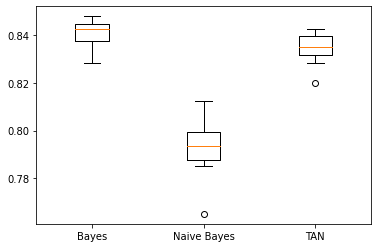

In [30]:
###################################################
# plot generator
import matplotlib.pyplot as plt

def plot():
    bayes_acc = cv_bayes(data)
    naive_acc = cv_naive(data)
    tan_acc = cv_tan(data)
    fig = plt.figure()
    plt.boxplot([bayes_acc, naive_acc, tan_acc], labels=['Bayes', 'Naive Bayes', 'TAN'])
    plt.savefig('imgs/result.jpg')

plot()

# Report

## Task 1 - Efficient d-seperation test
a. Analysis: We add few extra tests that covers $dsep_G(X,Y,Z)$ in the cases of sequential, divergent and convergent. These tests proves the correctness of our implementation. Run 10 test cases will take around $0.7 seconds$ which is $0.07 s/run$.

b. Complexity:
- Time: $V$ stands for number of vertex, $E$ stands for number of edges. Repeatedly pruning nodes can be done in $O(V)$ and pruning edges can be done in constant time $O(1)$. The time complexity for DFS is $O(V+E)$.
- Space: We make another undirected copy of pruned graph will would need extra memory $O(V+E)$. Luckily, the graph after pruning would be relatively smaller. During DFS, one color map of all vertex is created $O(V)$. 

## Task 2 – Estimate Bayesian Network parameters from data
a. Analysis: For each node in graph, we need to go through the table to construct the CPT table. Thanks for the efficiency of Pandas dataframe, the entire process can be done in $0.1s$.

b. Complexity: 
- Time: $O(VD)$ where $D$ is number of data
- Space: $O(VEO)$ where $O$ is number of entries in outcomeSpace


## Task 3 - Bayesian Network Classification 

a. Analysis: It takes 38.2 seconds to run the cross validation process with accuracy around 0.835. The graph is based on the causality proofed by experts which indicates the real independency between attributes.

b. Complexity:
- The time complexity of assess function n(sample size) times the complexity of query(). Which the complexity of cross validation is k times that of assess function.
- The space taken are simply linear to the graph and dataset.

## Task 4 - Naive bayes

a. Analysis:
By assuming attributes to be mutually independent with given target, naive bayes reduces the complexity of bayes net in significantly. It completed the classification task in 30 seconds which is 8 seconds less than that of the previous method. Even the accuracy is a little bit lower which is around 0.8 because of it's assumption on independence, it is still a good choice when dealing with small dataset with not significant internal correlation.

b. Complexity:
- The estimated time complexity of calculating $P(x|y_i)$ is $O(\Pi _i^N s_i)$ where $N$ is the number of attributes and $s_i$ represents the number of possible values of nth variable.
- The space complexity is similar to Bayes Net

## Task 5 - Tree-augmented Naive (TAN) Bayes Classification
a. Analysis:
During the process of calculating $MI(i;j|c)$ we store each $P(i|c)$ to avoid duplicate estimate factor. We store all MI data in a dict(dict) to reduce look up time to constant time.

b. Complexity:
The time and space complexity of calculating MI is $O(N^2)$ while $N$ is number of attributes. Complete_undirected_graph has time complexity of $O(V^2)$ with space $O(VE)$. Time complexity of Prim algorithm is $O(E\log{V})$. Adding query node to graph takes time of $O(V)$. The rest is essentially the same as Bayes Net.

## Conclusion
![](imgs/result.jpg)

From the boxplot above, we can see that the graph learnt by expert (Bayes Net) performed the best. The graph learnt from data using TAN outperforms that of Naive Bayes since it takes the dependencies between attributes into consideration. Furthermore, the standard deviation of Naive Bayes is the largest since it assumes the attributes are independent given the class
